In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [54]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [55]:
srate = 4096*4
t_range=np.arange(-1,1,1/srate)
input = dict(model_list = [(2,2,0, 'p')],
             t_init = 0,
             segment_length = 0.2,
             srate = 4096*4,
             ra = None, dec = None,)

## Error of relation

In [64]:
SNR_arr = []
err_arr = []

for i in range(500):
    injected = [np.random.uniform(45, 150, 1)[0], np.random.uniform(0, 0.85, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(signal, index=t_range), 2,2)
    waveform = qnm_filter.RealData(padded[1], index=padded[0])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = 0.1**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    template = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
    fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,1,'p')])
    template_res = fit.truncate_data(fit.filtered_data)['H1']
    SNR_res = fit.compute_SNR(None, template_res, 'H1', optimal=True)
    FF = np.sqrt(1-SNR_res**2/SNR**2)

    filt221_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
    filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

    error = (filt220_likelihood - filt221_likelihood)-((1-FF**2)*SNR**2/2)
    SNR_arr.append(SNR)
    err_arr.append(error)

Text(0.5, 1.0, 'Coverage test of pointwise relation')

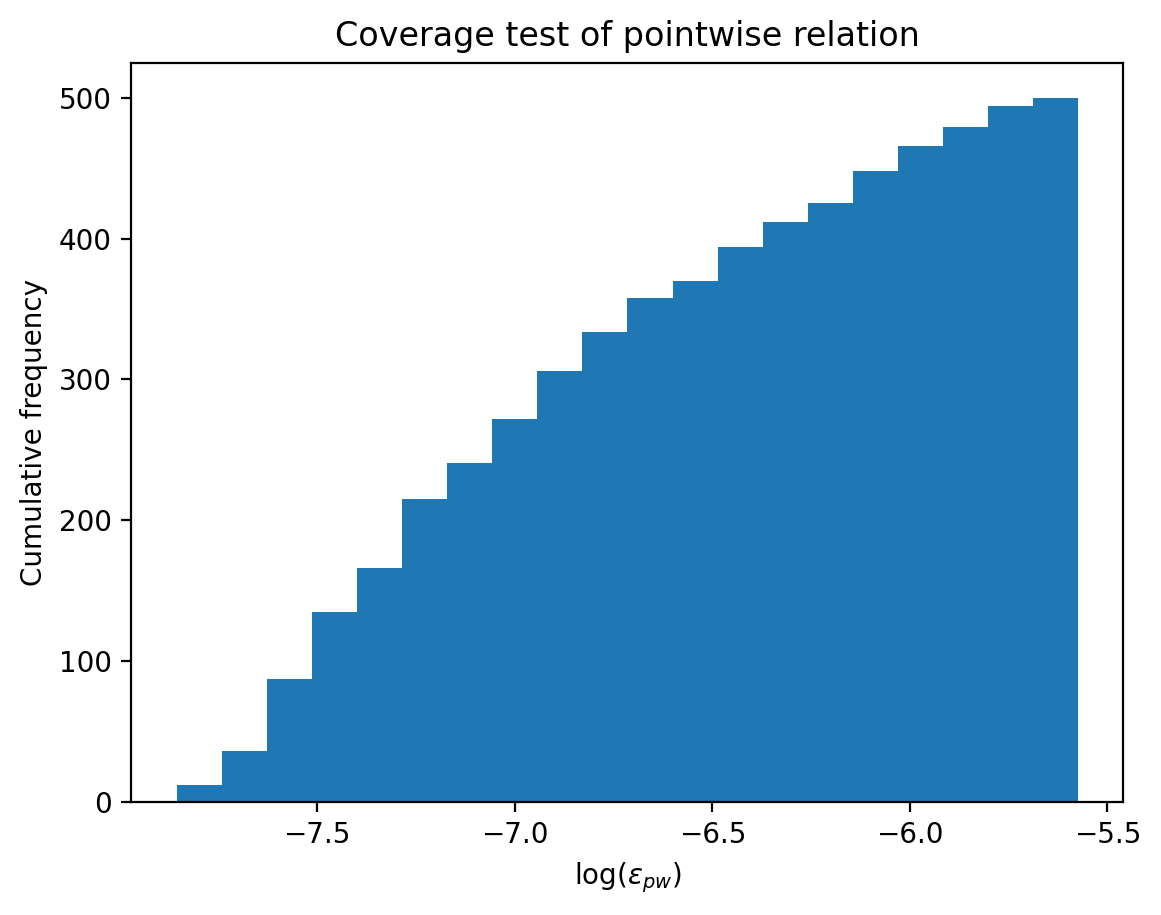

In [65]:
pl.hist(np.log10(np.abs(err_arr)), bins=20, cumulative=True);
pl.xlabel("log($\epsilon_{pw}$)")
pl.ylabel("Cumulative frequency")
pl.title("Coverage test of pointwise relation")

Text(0, 0.5, '$\\epsilon_{pw}$')

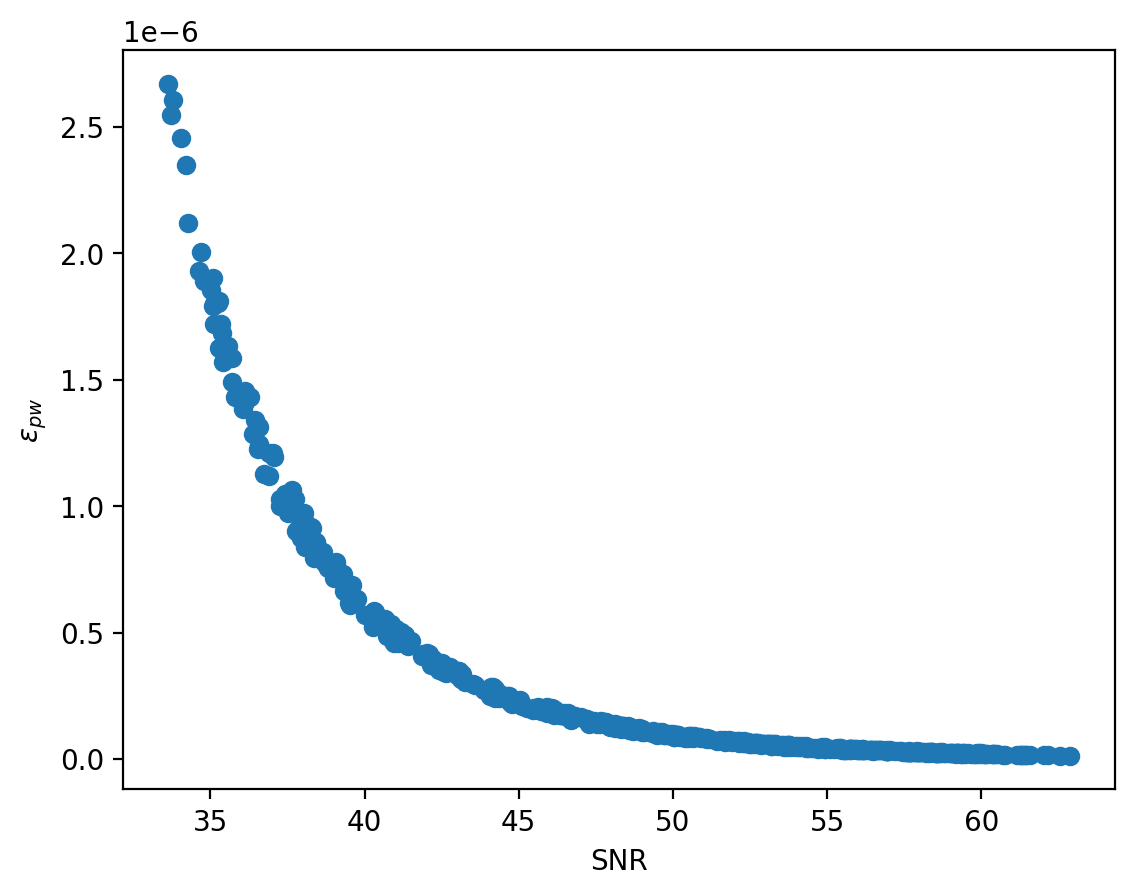

In [66]:
pl.plot(SNR_arr, np.abs(err_arr), 'o')
# pl.plot(SNR_arr, np.log10(np.abs(err_arr)), 'o')
pl.xlabel("SNR")
pl.ylabel("$\epsilon_{pw}$")

In [80]:
np.polyfit(SNR_arr, np.log10(np.abs(err_arr)), deg=1)

TypeError: expected x and y to have same length

## Likelihood ratio vs SNR

In [120]:
SNR_arr = []
likelihood_arr = []
N = 50

for i in range(N):
    injected = [50, 0.7]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(signal, index=t_range), 2,2)
    waveform = qnm_filter.RealData(padded[1], index=padded[0])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = ((i+1)/N)**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    template = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
    likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

    SNR_arr.append(SNR)
    likelihood_arr.append(likelihood)

Text(0.6, -4.75, 'Slope = 2')

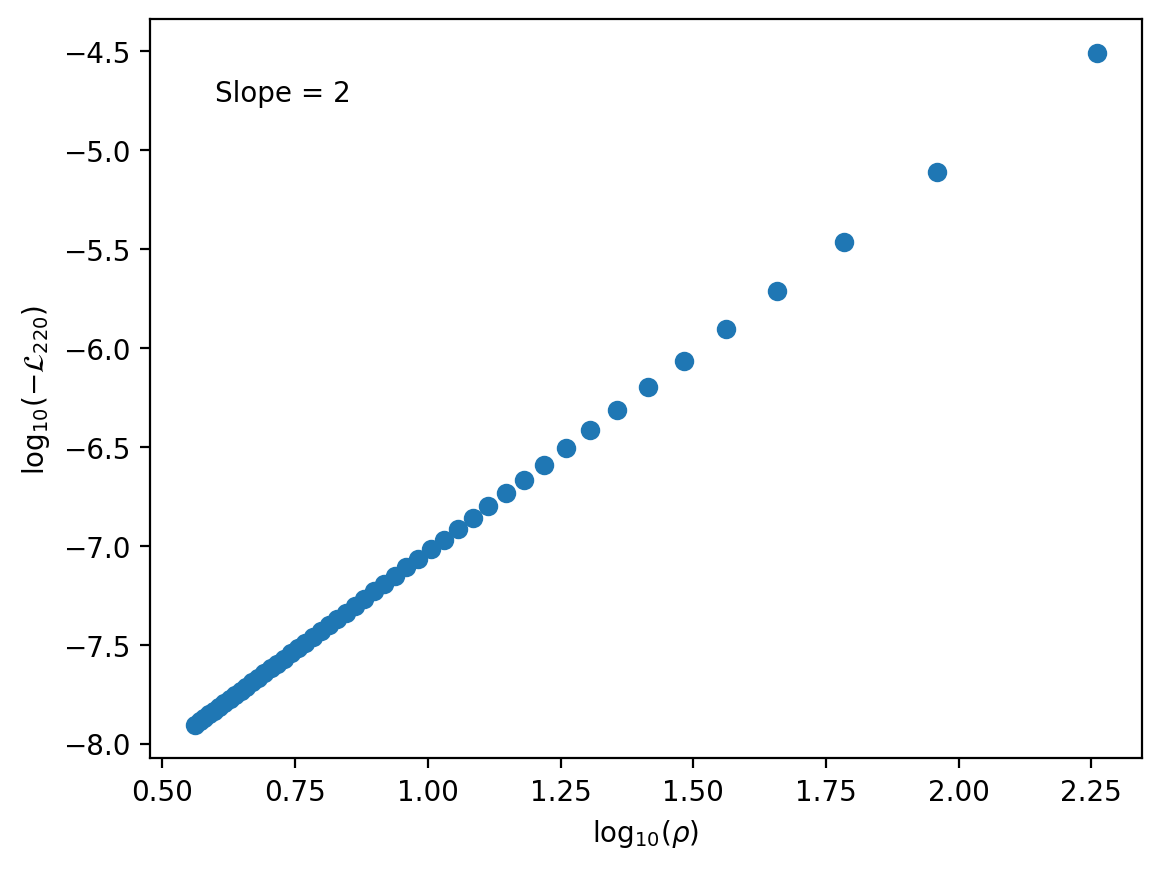

In [145]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{220}$)')
pl.text(0.6, -4.75, 'Slope = 2')

In [139]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)),deg=1, cov=True)

(array([ 2.        , -9.02775267]),
 array([[ 4.02242846e-32, -3.90472865e-32],
        [-3.90472865e-32,  4.37828975e-32]]))

## Interesting behaviour

In [151]:
SNR_arr = []
likelihood_arr = []

for i in range(200):
    injected = [np.random.uniform(45, 150, 1)[0], np.random.uniform(0, 0.85, 1)[0]]
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    mass = qnm_filter.Filter.mass_unit(injected[0])
    signal= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(signal, index=t_range), 2,2)
    waveform = qnm_filter.RealData(padded[1], index=padded[0])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = 0.1**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    template = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)

    filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

    SNR_arr.append(SNR)
    likelihood_arr.append(filt220_likelihood)

In [152]:
np.polyfit(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)),deg=1, cov=True)

(array([-8.21377125,  6.9404973 ]),
 array([[ 0.00035983, -0.0006071 ],
        [-0.0006071 ,  0.00102616]]))

Text(0.5, 1.0, 'Randomly chosen mass and chi')

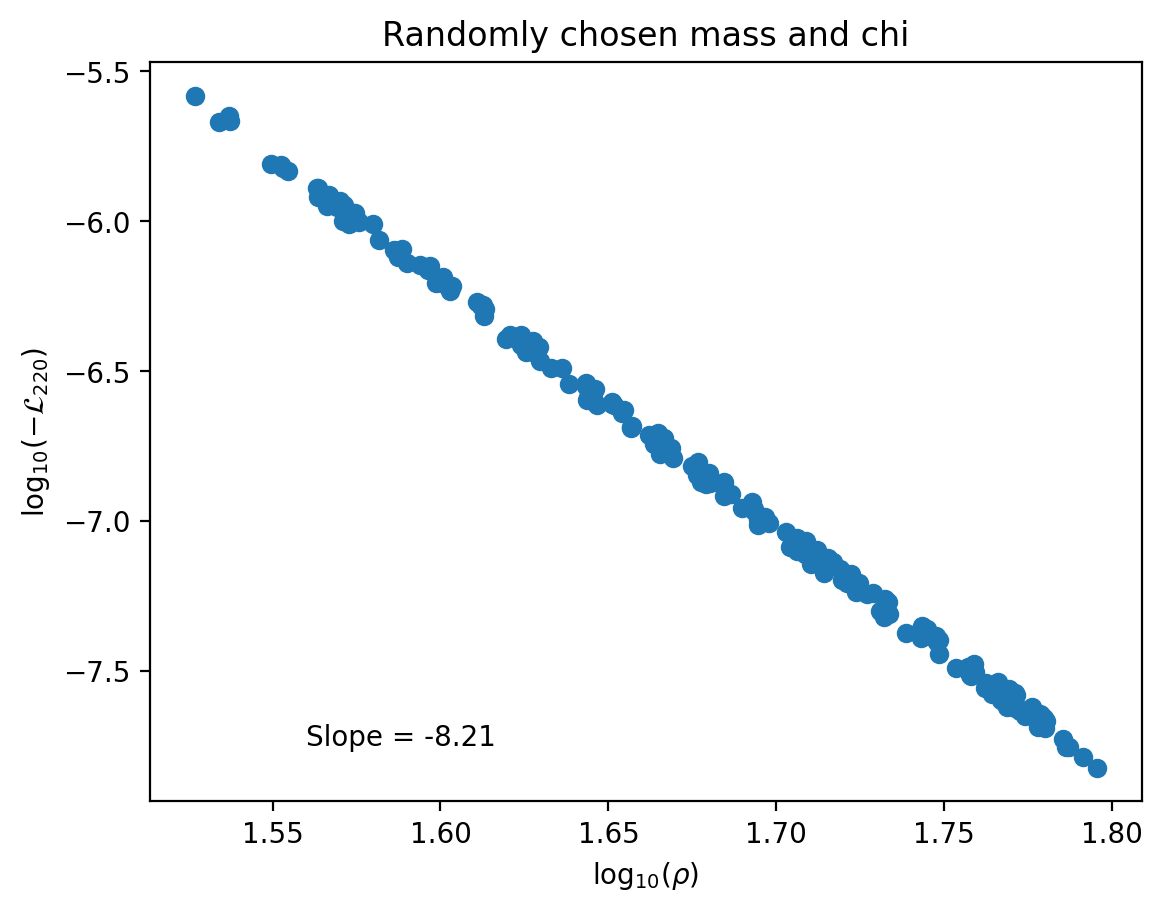

In [153]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{220}$)')
pl.text(1.56, -7.75, 'Slope = -8.21')
pl.title("Randomly chosen mass and chi")